In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

from jne_functions import *
from ipywidgets import interactive, FloatSlider
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df=pd.read_csv('bank_marketing_modified.csv')
df

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,cons.conf.idx,euribor3m,nr.employed,deposit,age_group,season,pdays_bin,year,employment,month_num
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,-36.4,4.857,5191.0,0,Adult,spring,0,2008,employed,5
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,41183,73,retired,married,professional.course,no,yes,no,cellular,nov,...,-50.8,1.028,4963.6,1,Senior,fall,0,2010,retired,11
41172,41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,...,-50.8,1.028,4963.6,0,Middle-aged,fall,0,2010,employed,11
41173,41185,56,retired,married,university.degree,no,yes,no,cellular,nov,...,-50.8,1.028,4963.6,0,Middle-aged,fall,0,2010,retired,11
41174,41186,44,technician,married,professional.course,no,no,no,cellular,nov,...,-50.8,1.028,4963.6,1,Middle-aged,fall,0,2010,employed,11


In [3]:
X=df.loc[:,['campaign','previous','emp.var.rate','poutcome','euribor3m','nr.employed',
            'cons.price.idx','cons.conf.idx','employment','marital','education',
            'housing','loan','day_of_week','pdays_bin','age_group','default','month','contact','year']]
y=df['deposit']

In [4]:
param_grid={'classifier__bootstrap': [True],
            'classifier__max_depth': np.arange(10,40,5),
            'classifier__max_features': ['sqrt',None],
            'classifier__min_samples_leaf':np.arange(10,50,5),
            'classifier__min_samples_split': np.arange(10,50,10),
            'classifier__n_estimators':np.arange(100,450,50)}
classifiers_no_stan(RandomForestClassifier(class_weight='balanced_subsample',oob_score=True,n_jobs=-1),X,y)
from jne_functions import pipe, X_train, X_test, y_train, y_test

f1 = make_scorer(f1_score , average='macro')
rand_RF=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_RF.fit(X_train,y_train)
rand_RF.best_params_

{'classifier__n_estimators': 400,
 'classifier__min_samples_split': 40,
 'classifier__min_samples_leaf': 10,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 35,
 'classifier__bootstrap': True}

In [5]:
confusion_matrix(y_test, rand_RF.predict(X_test))

array([[6303, 1005],
       [ 343,  585]])

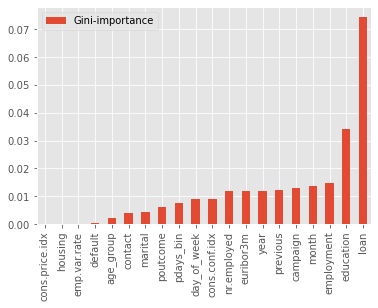

In [6]:
feats={}
for feature,importance in zip(X_train.columns, rand_RF.best_estimator_.named_steps['classifier'].feature_importances_):
    feats[feature]=importance
importances=pd.DataFrame.from_dict(feats,orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar',rot=90);

In [7]:
interactive(lambda threshold: make_confusion_matrix(rand_RF, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

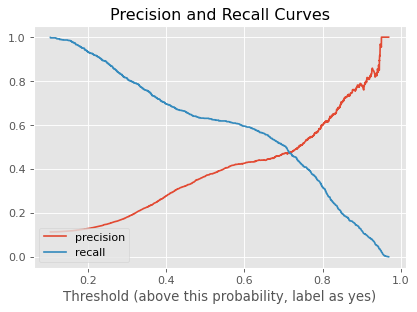

In [8]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rand_RF.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)');
plt.title('Precision and Recall Curves');

In [9]:
y_predict = rand_RF.predict(X_test)
f1_score(y_test, y_predict,average='macro')
#0.6115192438821742 with month and default
#0.5253684362828646 without
#0.6088428591731878 with nr.emp and emb

0.684025681568271

In [10]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7308
           1       0.37      0.63      0.46       928

    accuracy                           0.84      8236
   macro avg       0.66      0.75      0.68      8236
weighted avg       0.88      0.84      0.85      8236



In [11]:
RF_fpr, RF_tpr, thresholds = roc_curve(y_test, rand_RF.predict_proba(X_test)[:,1])

ROC AUC score =  0.7899637324707927


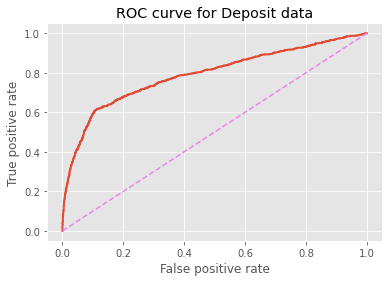

In [12]:
plt.plot(RF_fpr, RF_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit data');
print("ROC AUC score = ", roc_auc_score(y_test, rand_RF.predict_proba(X_test)[:,1]))

# SMOTE

In [13]:
param_grid={'classifier__bootstrap': [True],
            'classifier__max_depth': np.arange(10,50,5),
            'classifier__max_features': ['sqrt',None],
            'classifier__min_samples_leaf':np.arange(10,50,5),
            'classifier__min_samples_split': np.arange(10,40,2),
            'classifier__n_estimators':np.arange(50,500,50)}
classifiers_no_stan_oversample(RandomForestClassifier(n_jobs=-1),X,y)
from jne_functions import pipe, X_train, X_test, y_train, y_test

rand_RF_SMOTE=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_RF_SMOTE.fit(X_train,y_train)
rand_RF_SMOTE.best_params_

{'classifier__n_estimators': 150,
 'classifier__min_samples_split': 14,
 'classifier__min_samples_leaf': 10,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 30,
 'classifier__bootstrap': True}

In [14]:
confusion_matrix(y_test, rand_RF_SMOTE.predict(X_test))

array([[6661,  647],
       [ 415,  513]])

In [15]:
interactive(lambda threshold: make_confusion_matrix(rand_RF_SMOTE, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

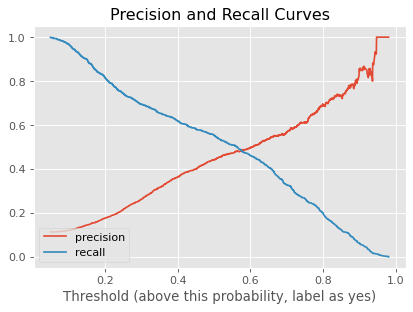

In [16]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rand_RF_SMOTE.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)');
plt.title('Precision and Recall Curves');

In [17]:
y_predict = rand_RF_SMOTE.predict(X_test)
f1_score(y_test, y_predict,average='macro')
#0.6258662180390302 with month, default
#0.5394854988662527 without
#0.6349061925490956 with nr.emp and emb

0.708773637374861

In [18]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7308
           1       0.44      0.55      0.49       928

    accuracy                           0.87      8236
   macro avg       0.69      0.73      0.71      8236
weighted avg       0.89      0.87      0.88      8236



ROC AUC score =  0.784033248282468


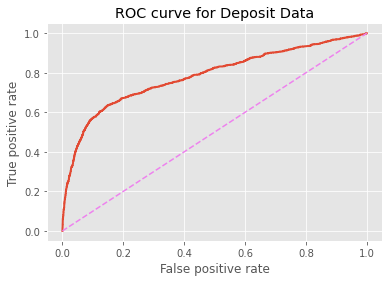

In [19]:
RFS_fpr, RFS_tpr, thresholds = roc_curve(y_test, rand_RF_SMOTE.predict_proba(X_test)[:,1])
plt.plot(RFS_fpr, RFS_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit Data');
print("ROC AUC score = ", roc_auc_score(y_test, rand_RF_SMOTE.predict_proba(X_test)[:,1]))

In [20]:
rand_RF_SMOTE.best_estimator_.named_steps['classifier'].feature_importances_

array([0.01798483, 0.01197208, 0.00002855, 0.00652073, 0.0120209 ,
       0.0134564 , 0.        , 0.00982418, 0.01918615, 0.00456144,
       0.07087151, 0.        , 0.08029504, 0.00907803, 0.00576883,
       0.00322919, 0.00021062, 0.01177624, 0.00249594, 0.0108383 ,
       0.01426133, 0.01763649, 0.05787008, 0.01066187, 0.02165026,
       0.00777464, 0.00154048, 0.043509  , 0.00166476, 0.03274938,
       0.02295546, 0.02014637, 0.01986963, 0.0173966 , 0.04612884,
       0.01508879, 0.01797846, 0.06037944, 0.07650668, 0.1093199 ,
       0.09479258])

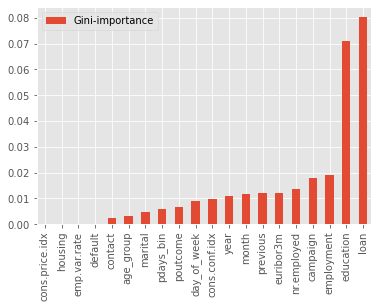

In [21]:
feats={}
for feature,importance in zip(X_train.columns, rand_RF_SMOTE.best_estimator_.named_steps['classifier'].feature_importances_):
    feats[feature]=importance
importances=pd.DataFrame.from_dict(feats,orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar',rot=90);

# UNDERSAMPLING

In [22]:
param_grid={'classifier__bootstrap': [True],
            'classifier__max_depth': np.arange(10,40,5),
            'classifier__max_features': ['sqrt',None],
            'classifier__min_samples_leaf':np.arange(10,50,5),
            'classifier__min_samples_split': np.arange(10,50,10),
            'classifier__n_estimators':np.arange(100,450,50)}
classifiers_no_stan_undersample(RandomForestClassifier(n_jobs=-1),X,y)

from jne_functions import pipe, X_train, X_test, y_train, y_test

rand_RF_UNDER=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_RF_UNDER.fit(X_train,y_train)
rand_RF_UNDER.best_params_

{'classifier__n_estimators': 200,
 'classifier__min_samples_split': 40,
 'classifier__min_samples_leaf': 40,
 'classifier__max_features': None,
 'classifier__max_depth': 25,
 'classifier__bootstrap': True}

In [23]:
confusion_matrix(y_test, rand_RF_UNDER.predict(X_test))

array([[6218, 1090],
       [ 355,  573]])

In [24]:
interactive(lambda threshold: make_confusion_matrix(rand_RF_UNDER, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

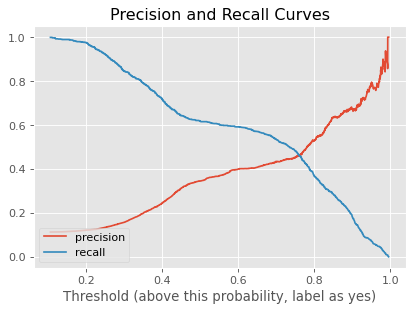

In [25]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rand_RF_UNDER.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)');
plt.title('Precision and Recall Curves');

In [26]:
y_predict = rand_RF_UNDER.predict(X_test)
f1_score(y_test, y_predict,average='macro')

0.6691005709305409

In [27]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7308
           1       0.34      0.62      0.44       928

    accuracy                           0.82      8236
   macro avg       0.65      0.73      0.67      8236
weighted avg       0.88      0.82      0.84      8236



ROC AUC score =  0.7835566066002303


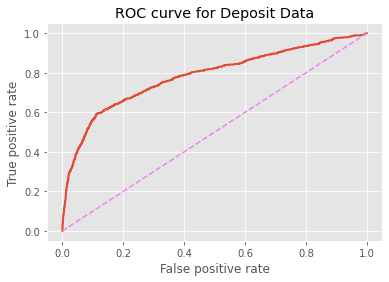

In [28]:
RFU_fpr, RFU_tpr, thresholds = roc_curve(y_test, rand_RF_UNDER.predict_proba(X_test)[:,1])
plt.plot(RFU_fpr, RFU_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit Data');
print("ROC AUC score = ", roc_auc_score(y_test, rand_RF_UNDER.predict_proba(X_test)[:,1]))

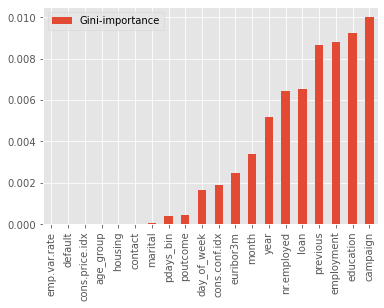

In [29]:
feats={}
for feature,importance in zip(X_train.columns, rand_RF_UNDER.best_estimator_.named_steps['classifier'].feature_importances_):
    feats[feature]=importance
importances=pd.DataFrame.from_dict(feats,orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar',rot=90);

# BalancedRandomForestClassifier

In [30]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [31]:
param_grid={'classifier__bootstrap': [True],
            'classifier__max_depth': np.arange(10,40,5),
            'classifier__max_features': ['sqrt',None],
            'classifier__min_samples_leaf':np.arange(10,50,5),
            'classifier__min_samples_split': np.arange(10,50,10),
            'classifier__n_estimators':np.arange(100,450,50)}
classifiers_no_stan(BalancedRandomForestClassifier(class_weight='balanced_subsample',n_jobs=-1),X,y)
from jne_functions import pipe, X_train, X_test, y_train, y_test

rand_RF_BAL=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_RF_BAL.fit(X_train,y_train)
rand_RF_BAL.best_params_

{'classifier__n_estimators': 300,
 'classifier__min_samples_split': 20,
 'classifier__min_samples_leaf': 10,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 30,
 'classifier__bootstrap': True}

In [32]:
confusion_matrix(y_test, rand_RF_BAL.predict(X_test))

array([[6146, 1162],
       [ 329,  599]])

In [33]:
interactive(lambda threshold: make_confusion_matrix(rand_RF_BAL, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

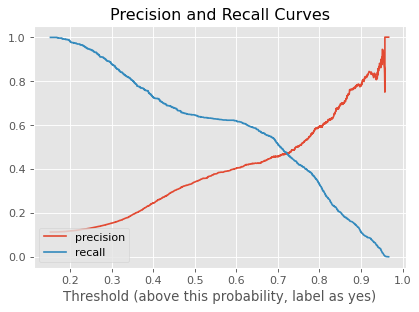

In [34]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rand_RF_BAL.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)');
plt.title('Precision and Recall Curves');

In [35]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7308
           1       0.34      0.62      0.44       928

    accuracy                           0.82      8236
   macro avg       0.65      0.73      0.67      8236
weighted avg       0.88      0.82      0.84      8236



ROC AUC score =  0.7923635293395996


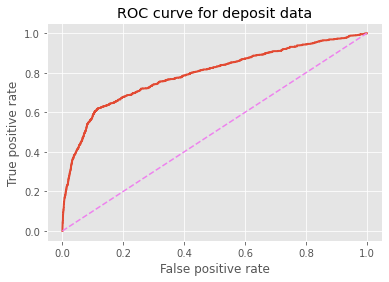

In [36]:
RFB_fpr, RFB_tpr, thresholds = roc_curve(y_test, rand_RF_BAL.predict_proba(X_test)[:,1])
plt.plot(RFB_fpr, RFB_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for deposit data');
print("ROC AUC score = ", roc_auc_score(y_test, rand_RF_BAL.predict_proba(X_test)[:,1]))

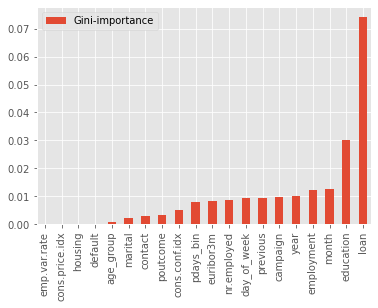

In [37]:
feats={}
for feature,importance in zip(X_train.columns, rand_RF_BAL.best_estimator_.named_steps['classifier'].feature_importances_):
    feats[feature]=importance
importances=pd.DataFrame.from_dict(feats,orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar',rot=90);